# Statistical and numerical methods in cosmology
# HW #2 
### *Hernán E. Noriega B.*
### Instituto de Física, Universidad Nacional Autónoma de México

In [1]:
import numpy as np
import math
import statistics
from sympy import integrate
from scipy.integrate import quad
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d

## Distributing particles onto the regular grid

In [2]:
x, y, z = np.loadtxt('Halo_list_NO_FOFR_1000.txt',usecols=(0,1,2),unpack=True) 

#x: it is the x's coordinate, and so on... (units: Mpc/h)

In [3]:
grid_size = 10 #grid_size given by HW#2
den_arr = np.zeros((10*grid_size,10*grid_size,10*grid_size)) #(100,100,100) density arr

#NGP particle distribution scheme
for ii in range(len(x)):
    i = int(np.floor(x[ii])/grid_size) 
    j = int(np.floor(y[ii])/grid_size)
    k = int(np.floor(z[ii])/grid_size)  
    den_arr[i][j][k] = den_arr[i][j][k]+1

den_arr = den_arr/grid_size**3 #number density

### Density $\rho(x,y,z)$ 

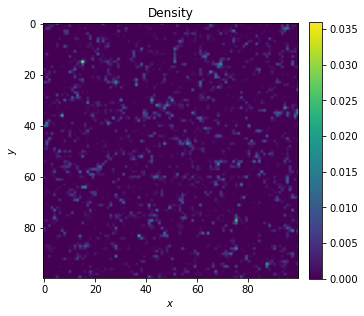

In [4]:
plt.figure(figsize = (5,5))
im = plt.imshow(den_arr[:,:,0]) #z=0
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Density')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## Fourier transformation

First we define the overdensity,

$$\delta (r)=\frac { \rho (r)-\bar { \rho  }  }{ \bar { \rho  }  } $$

In [5]:
#overdensity: $\delta(r)$
delta_r = den_arr/np.mean(den_arr)-1  

#FT of $\delta(r)$ -> $\delta(k)$ 
delta_k = np.fft.fftn(delta_r) 
delta_k_shift = np.fft.fftshift(delta_k) #delta_k organized
RE_delta_k = np.fft.fftshift(delta_k.real) #real part organized
IM_delta_k = np.fft.fftshift(delta_k.imag) #imag part organized


### Frequency
 The Nyquist frequency (max frequency without aliasing) $K_{Ny}$ and the $K_{min}$ are given by,  
 
 $$K_{Ny}={\pi N}/{L} \quad \& \quad  K_{min}> 2\pi/L$$
 
 $N$ is the cube root of the total number of particles, and $L$ is the length of the cubic box.
 see: https://arxiv.org/pdf/1610.04862.pdf
 
 Here: $N=100$ and $L=1000$

In [6]:
#we obtain kmin and kmax using the formula above
kmin = 2*np.pi/1000
kmax = np.pi/10

#frecuency (for each coordinate, all are eq kx=ky=kz=k) 
k = np.fft.fftshift(np.fft.fftfreq(100, 10)*2*np.pi) 
print("k_max:",np.amax(np.abs(k)))
print("k_min:", kmin)

k_max: 0.3141592653589793
k_min: 0.006283185307179587


### Real and imaginary part of the $\delta(\vec { k } )$

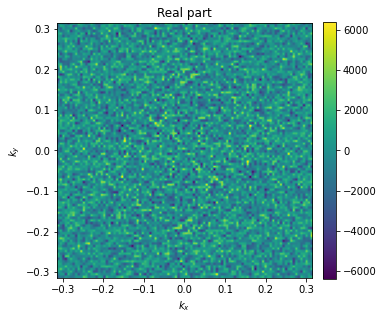

In [7]:
plt.figure(figsize = (5,5))
im = plt.imshow(RE_delta_k[:,:,0],extent = [-kmax , kmax, -kmax, kmax]) #z=0
plt.colorbar(im,fraction = 0.046, pad = 0.04)
plt.title(r'Real part')
plt.xlabel(r'${k_x}$')
plt.ylabel(r'${k_y}$')
plt.show()

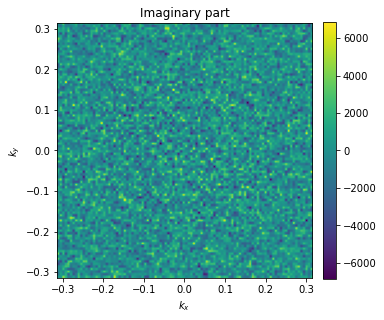

In [8]:
plt.figure(figsize = (5,5))
im = plt.imshow(IM_delta_k[:,:,0], extent = [-kmax , kmax, -kmax, kmax]) #z=0
plt.colorbar(im,fraction = 0.046, pad = 0.04)
plt.title(r'Imaginary part')
plt.xlabel(r'${k_x}$')
plt.ylabel(r'${k_y}$')
plt.show()

## Estimating power spectrum

In [9]:
#we define the distance function as "D(kx,ky,kz)"
def D(kx,ky,kz):
    return math.sqrt(kx**2+ky**2+kz**2) 

#we define the variance method (Bessel's correction)
def var_method(lst): 
    n = len(lst)
    return sum((x) ** 2 for x in lst) / float(n - 1) 

In [10]:
step = np.linspace(kmin,kmax,50) #steps +0.00628 = kmin (aprox)
k_mod = np.zeros((len(k),len(k),len(k))) #modulus/distances
p_k = np.zeros(len(step)) #power spectrum

#we calculate de distances
for ii in range(len(k)):
    for jj in range(len(k)):
        for kk in range(len(k)):
            k_mod[ii,jj,kk] = D(k[ii],k[jj],k[kk])

#we classify the vector by intervals, np.where() return a tuple of indices
for jj in range(1,len(step)):
    k_index = np.where( (k_mod < step[jj]) & (k_mod >= step[jj-1]) )
    k_x = k_index[0]
    k_y = k_index[1]
    k_z = k_index[2]
    p_k[jj] = var_method(np.abs(delta_k_shift[k_x,k_y,k_z]))

#check N-point-stat.pdf
L = 1000
N = 100
norm_factor = L**3/N**6 #normalization factor (FFTW convention)
p_k = np.delete(p_k,0)*norm_factor 

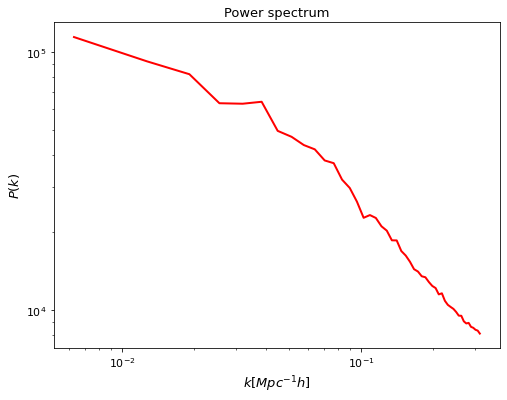

In [11]:
k_range = np.linspace(kmin,kmax,len(p_k)) 

plt.figure(figsize = (8,6))
plt.title(r'Power spectrum',fontsize=13)
plt.xlabel(r'$k[Mpc^{-1} h]$',fontsize=13)
plt.ylabel(r'$P(k)$',fontsize=13)

plt.loglog(k_range,p_k,color='red',ls='-',lw=2) #loglog plot 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

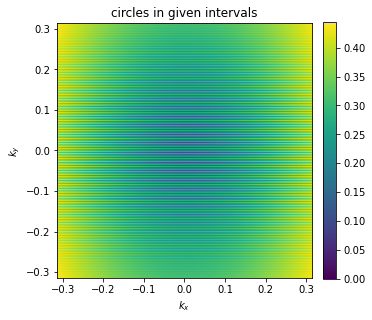

In [12]:
#circles in given intervals (2D plot) -- extra isn't at HW
plt.figure(figsize = (5,5))
plt.title(r'circles in given intervals')
im = plt.imshow(k_mod[k_x,k_y], extent = [-kmax , kmax, -kmax, kmax]) 
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'${k_x}$')
plt.ylabel(r'${k_y}$')
plt.show()

## Deconvolving window function

For Nearest grid point, NGP

$$P(\vec { k } )={ P }^{ m }({ k }_{ x },{ k }_{ y },{ k }_{ z }){ \left[ sinc\left( \frac { \pi { k }_{ x } }{ 2{ k }_{ N } }  \right) sinc\left( \frac { \pi { k }_{ y } }{ 2{ k }_{ N } }  \right) sinc\left( \frac { \pi { k }_{ z } }{ 2{ k }_{ N } }  \right)  \right]  }^{ -2 }$$

where, $W(\vec { k })=sinc\left( \frac { \pi { k }_{ x } }{ 2{ k }_{ N } }  \right) sinc\left( \frac { \pi { k }_{ y } }{ 2{ k }_{ N } }  \right) sinc\left( \frac { \pi { k }_{ z } }{ 2{ k }_{ N } }  \right) $ is the window function for NGP

In [13]:
#convention: np.sinc(x) = sin(pi x)/(pi x), this def has the pi
#check: https://numpy.org/doc/stable/reference/generated/numpy.sinc.html

k_n = (np.pi*100)/1000 #k_n is the KNyquist

#3D window function
def w_ngp(k_x, k_y, k_z):
    return np.sinc(k_x/(2*k_n))*np.sinc(k_y/(2*k_n))*np.sinc(k_z/(2*k_n)) 

In [14]:
#Power spectrum with NGP window function
p_k_ngp = np.zeros(len(step))

for jj in range(1,len(step)):
    k_index = np.where( (k_mod < step[jj]) & (k_mod >= step[jj-1]) )
    k_x = k_index[0]
    k_y = k_index[1]
    k_z = k_index[2]
    p_k_ngp[jj] = var_method(np.abs(delta_k_shift[k_x,k_y,k_z])/w_ngp(k[k_x],k[k_y],k[k_z]))

#check N-point-stat.pdf
L = 1000
N = 100
norm_factor = L**3/N**6 #normalization factor (FFTW convention)
p_k_ngp = np.delete(p_k_ngp,0)*norm_factor 

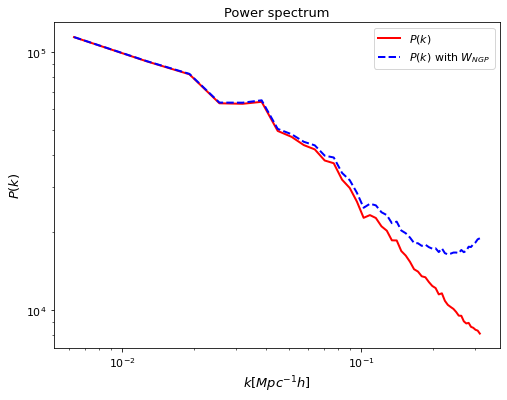

In [15]:
k_range = np.linspace(kmin,kmax,len(p_k_ngp))

plt.figure(figsize = (8,6))
plt.title(r'Power spectrum',fontsize=13)
plt.xlabel(r'$k[Mpc^{-1} h]$',fontsize=13)
plt.ylabel(r'$P(k)$',fontsize=13)

plt.loglog(k_range,p_k,color='red',ls='-',lw=2,label=r'$P(k)$')
plt.loglog(k_range,p_k_ngp,color='blue',ls='--',lw=2,label=r'$P(k)$ with $W_{NGP}$')

plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


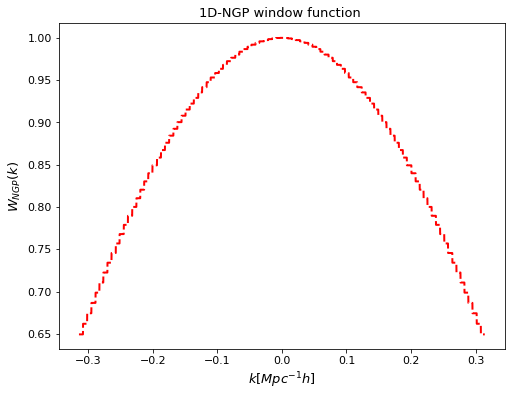

In [16]:
#extra isn't at HW
k_range = np.linspace(-kmax,kmax,w_ngp(k[k_x],0,0).size)

plt.figure(figsize = (8,6))
plt.title(r'1D-NGP window function ',fontsize=13)
plt.xlabel(r'$k[Mpc^{-1} h]$',fontsize=13)
plt.ylabel(r'$W_{NGP}(k)$',fontsize=13)

#we use the k index obtained above
plt.plot(k_range,w_ngp(k[k_x],0,0),color='red',ls='--',lw=2)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

## Subtracting shot noise

In [17]:
p_k_shot = p_k_ngp - 1/np.mean(den_arr)

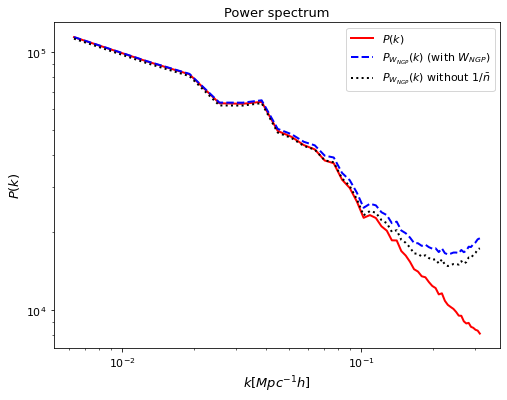

In [18]:
k_range = np.linspace(kmin,kmax,len(p_k_ngp))

plt.figure(figsize = (8,6))
plt.title(r'Power spectrum',fontsize=13)
plt.xlabel(r'$k[Mpc^{-1} h]$',fontsize=13)
plt.ylabel(r'$P(k)$',fontsize=13)

plt.loglog(k_range,p_k,color='red',ls='-',lw=2,label=r'$P(k)$')
plt.loglog(k_range,p_k_ngp,color='blue',ls='--',lw=2,label=r'$P_{W_{NGP}}(k)$ (with $W_{NGP})$')
plt.loglog(k_range,p_k_shot,color='k',ls=':',lw=2,label=r'$P_{W_{NGP}} (k)$ without $1/\bar{n}$')

plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()
